# YouTube on Android

The goal of this experiment is to run Youtube videos on a Pixel device running Android and collect results.

In [2]:
from conf import LisaLogging
LisaLogging.setup()

2018-03-26 15:51:58,904 INFO    : root         : Using LISA logging configuration:
2018-03-26 15:51:58,905 INFO    : root         :   /usr/local/google/home/kevindubois/source/android-pi-dev/external/lisa/logging.conf


In [3]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import System, Screen, Workload

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [4]:
def experiment():
    
    # Configure governor
    target.cpufreq.set_all_governors('sched')

    # Get workload
    wload = Workload(te).getInstance(te, 'YouTube')
    
    # Run Youtube workload
    wload.run(te.res_dir, 'https://youtu.be/XSGBVzeBUbk?t=45s',
              video_duration_s=60, collect='ftrace')

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [5]:
# Setup target configuration
my_conf = {
    # Target platform and board
    "platform"     : 'android',
    "board"        : 'pixel',
    
    # Device
    #"device"       : "FA6A10306347",
    
    # Android home
    "ANDROID_HOME" : "/usr/local/google/home/kevindubois/Android/Sdk",

    # Folder where all the results will be collected
    "results_dir" : "Youtube_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
            "clock_enable",
            "clock_disable",
            "clock_set_rate"
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
}

In [6]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False)
target = te.target

2018-03-26 15:51:59,748 INFO    : TestEnv      : Using base path: /usr/local/google/home/kevindubois/source/android-pi-dev/external/lisa
2018-03-26 15:51:59,750 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-03-26 15:51:59,751 INFO    : TestEnv      : External tools using:
2018-03-26 15:51:59,752 INFO    : TestEnv      :    ANDROID_HOME: /usr/local/google/home/kevindubois/Android/Sdk
2018-03-26 15:51:59,753 INFO    : TestEnv      :    CATAPULT_HOME: /usr/local/google/home/kevindubois/source/android-pi-dev/external/lisa/tools/catapult
2018-03-26 15:51:59,755 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq']
2018-03-26 15:51:59,756 INFO    : TestEnv      : Connecting Android target [DEFAULT]
2018-03-26 15:51:59,757 INFO    : TestEnv      : Connection settings:
2018-03-26 15:51:59,758 INFO    : TestEnv      :    None
2018-03-26 15:52:03,794 INFO    : TestEnv      : Initializing target workdir:
2018-03-26 15:52:03,797 INFO    : TestEnv      :   

## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **Youtube** experiment.

In [7]:
# Intialize Workloads for this test environment
results = experiment()

2018-03-26 15:52:06,298 INFO    : Workload     : Supported workloads available on target:
2018-03-26 15:52:06,301 INFO    : Workload     :   viewerworkload, youtube, camerapreview, gmaps
2018-03-26 15:52:06,303 INFO    : Screen       : Setting screen ON
2018-03-26 15:52:08,913 INFO    : Screen       : Force manual orientation
2018-03-26 15:52:08,916 INFO    : Screen       : Set orientation: LANDSCAPE
2018-03-26 15:52:10,259 INFO    : Screen       : Set brightness: 0%
2018-03-26 15:52:13,443 INFO    : YouTube      : FTrace START
2018-03-26 15:52:13,767 INFO    : YouTube      : Play video for 60 [s]
2018-03-26 15:53:14,133 INFO    : YouTube      : FTrace STOP
2018-03-26 15:53:24,043 INFO    : Screen       : Set orientation: AUTO
2018-03-26 15:53:25,025 INFO    : Screen       : Set brightness: AUTO


## Benchmarks results

In [8]:
# Benchmark statistics
db_file = os.path.join(te.res_dir, "framestats.txt")
!sed '/Stats since/,/99th/!d;/99th/q' {db_file}

# For all results:
# !cat {results['db_file']}

Stats since: 277544731072708ns
Total frames rendered: 210
Janky frames: 9 (4.29%)
50th percentile: 6ms
90th percentile: 11ms
95th percentile: 14ms
99th percentile: 48ms


## Traces visualisation

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [9]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.dat')
trace = Trace(trace_file, my_conf['ftrace']['events'], platform)

trappy.plotter.plot_trace(trace.ftrace)

2018-03-26 15:54:48,177 INFO    : Trace        : Platform clusters verified to be Frequency coherent
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


2018-03-26 15:55:31,931 INFO    : Analysis     : LITTLE cluster average frequency: 0.637 GHz
2018-03-26 15:55:31,933 INFO    : Analysis     : big    cluster average frequency: 0.509 GHz


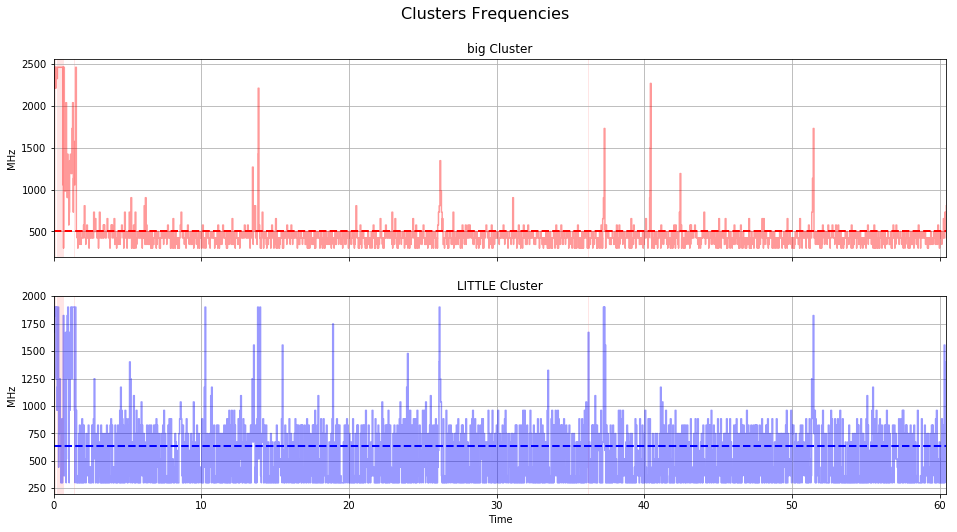

In [10]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass

2018-03-26 15:55:32,796 INFO    : Analysis     : LITTLE cluster average frequency: 0.637 GHz
2018-03-26 15:55:32,798 INFO    : Analysis     : big    cluster average frequency: 0.509 GHz


(0.63711042295575748, 0.50915364765824211)

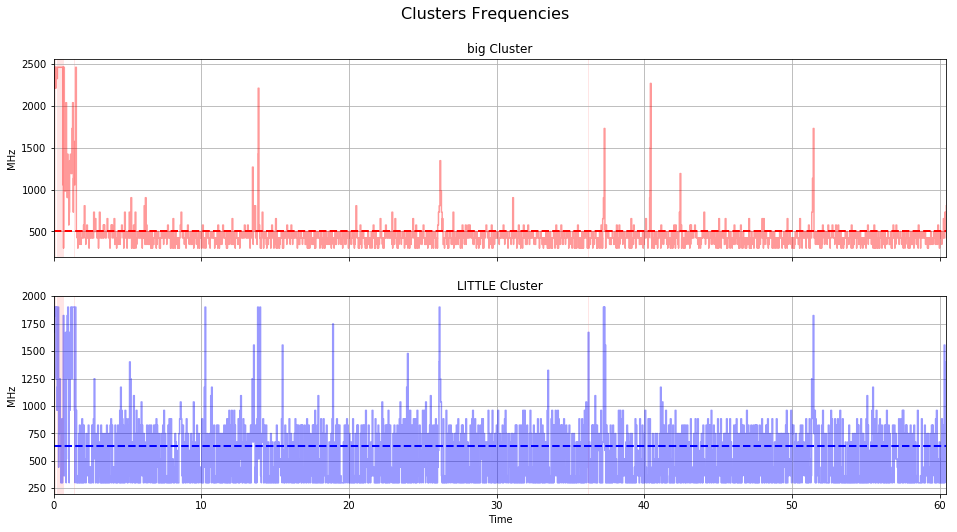

In [11]:
trace.analysis.frequency.plotClusterFrequencies()


2018-03-26 16:00:11,487 WARNING : Analysis     : No effective frequency events to plot


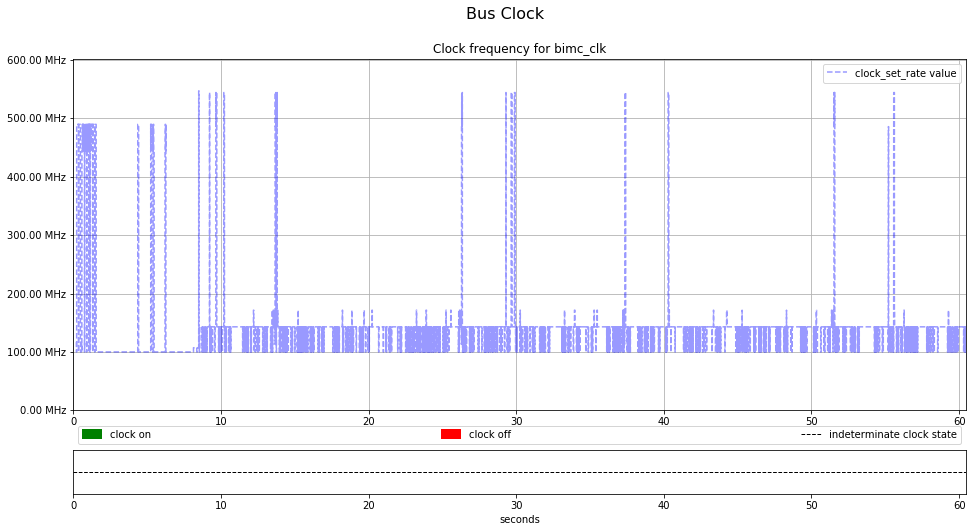

In [15]:
trace.analysis.frequency.plotPeripheralClock(title="Bus Clock", clk="bimc_clk")
